# Note: This notebook is a work in progress & will be updated continuously until it's ready - 28 May 2021

# Time series forecasting in TensorFlow

The goal of this notebook is to get you familiar with working with time series data.

It won't cover all of the time series field but by the end you will get a fairly good overview of things to consider for time series problems...

### What we're going to cover
* Get data (a time series)
* Format data
  * Turn data into a windowed dataset
  * Training/test sets for time series
  * Univariate - Bitcoin's price history
  * Multivariate - Bitcoin's price history + block size
* Model data
  * Baseline - naive forecasting (use the last timestep to predict the next timestep)
  * Deep model - fully connected
  * Sequence models
    * LSTM
    * Conv1D
  * N-Beats algorithm - https://arxiv.org/pdf/1905.10437.pdf
* Evaluating a time series model
  * MAE
  * MSE
  * RMSE etc...
* Uncertainty estimates
  * Coconut uncertainty - epistemic uncertainty
  * Subway uncertainty - aleatory uncertainty
* Why forecasting is BS (turkey problem) - https://youtu.be/hRwimmE2wEk
  * Open system: beware (like fortune telling), see Mark Saroufim's tweet - https://twitter.com/marksaroufim/status/1366871736604532739?s=20 
  * Closed system: try it out 
* Exercises
* Extra-curriculum
  * Time series book - https://otexts.com/fpp2/accuracy.html 


## TODO: What is a time series problem?

* Forecasting
* Classification

## TODO: Get data

Let's predict the price of Bitcoin! Data source: https://www.coindesk.com/price/bitcoin

> **Note:** This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

See this tweet for reference: https://twitter.com/marksaroufim/status/1366871736604532739?s=20

TODO (upload to Google Storage/GitHub): Data: https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv?dl=0

In [1]:
!wget https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-05-29 19:01:30--  https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv [following]
--2021-05-29 19:01:30--  https://www.dropbox.com/s/raw/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc04366d5cf4cf04abe66a140c3e.dl.dropboxusercontent.com/cd/0/inline/BPZq6D-4gFHNia3T_gh9p9nLcROyeRvzlmu3eXvlcuu985HlnsGDakp3U6_LmdnyT1lvfDnpBpaBOZt2Xah_s6kZPxl59jrPiPRXdFA9q8DHPz_2l2xerz5gb0-DVpdZygSQxEmHdcGrbGcMJL9t3nfp/file# [following]
--2021-05-29 19:01:30--  https://uc04366d5cf4cf04abe66a140c3e.dl.dropboxusercontent.com/cd/0/inline/

In [316]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("DOE-001-050-10DU 03.csv", 
                 #parse_dates=["Date"], 
                 index_col=["index"]) # parse the date column (tell pandas column 1 is a datetime)
df

,Date_Time,Test_Time(s),Step_Time(s),Step_Index,Cycle_Index,Voltage,Current(A),Charge_Capacity,Discharge_Capacity,Charge_Energy(Wh),Discharge_Energy(Wh),ACR(Ohm),Internal Resistance(Ohm)
index,,,,,,,,,,,,,
0,01/27/2018 15:48:07.529,120.000800,120.0007,1,1,3.400125,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,NaN
1,01/27/2018 15:50:07.528,240.000000,239.9999,1,1,3.400786,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,NaN
2,01/27/2018 15:52:07.529,360.000800,360.0007,1,1,3.401296,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,NaN
3,01/27/2018 15:54:07.529,480.000800,480.0007,1,1,3.401689,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,NaN
4,01/27/2018 15:56:07.529,600.000800,600.0007,1,1,3.402061,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,02/01/2018 05:35:13.115,388324.753408,7680.0002,9,51,4.400060,0.095040,2.860948,6.190000e-10,12.376718,2.283000e-09,NaN,NaN
3409,02/01/2018 05:37:13.116,388444.754208,7800.0010,9,51,4.400060,0.091077,2.864044,6.190000e-10,12.390339,2.283000e-09,NaN,NaN
3410,02/01/2018 05:39:13.115,388564.753408,7920.0002,9,51,4.400067,0.087433,2.867008,6.190000e-10,12.403381,2.283000e-09,NaN,NaN


In [317]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3413 entries, 0 to 3412
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date_Time                 3413 non-null   object 
 1   Test_Time(s)              3413 non-null   float64
 2   Step_Time(s)              3413 non-null   float64
 3   Step_Index                3413 non-null   int64  
 4   Cycle_Index               3413 non-null   int64  
 5   Voltage                   3413 non-null   float64
 6   Current(A)                3413 non-null   float64
 7   Charge_Capacity           3413 non-null   float64
 8   Discharge_Capacity        3413 non-null   float64
 9   Charge_Energy(Wh)         3413 non-null   float64
 10  Discharge_Energy(Wh)      3413 non-null   float64
 11  ACR(Ohm)                  0 non-null      float64
 12  Internal Resistance(Ohm)  0 non-null      float64
dtypes: float64(10), int64(2), object(1)
memory usage: 373.3+ KB


In [318]:
# TODO: time series often may not have very many samples (e.g. monthly = only 12 per year, daily = 365 per year... etc)
# Deep learning algorithms usually flourish with lots of data (1000's of samples)
len(df)

3413

In [429]:
# Only want closing price
data_rawdata = pd.DataFrame(df["Discharge_Capacity"])
data_rawdata.head()

,Discharge_Capacity
index,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [430]:
data_rawdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3413 entries, 0 to 3412
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Discharge_Capacity  3413 non-null   float64
dtypes: float64(1)
memory usage: 53.3 KB


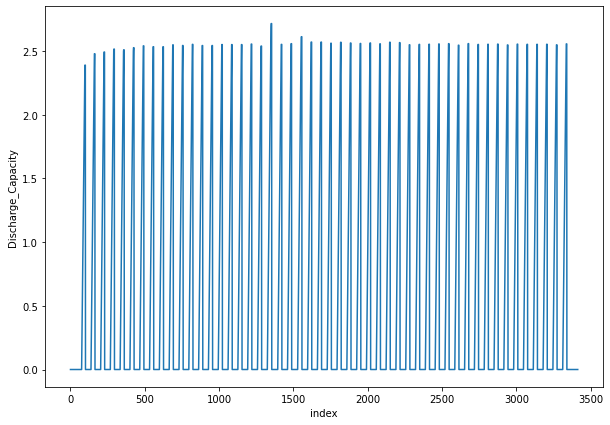

In [431]:
#data_rawdata.plot(figsize=(10, 7));
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot( np.array(data_rawdata))
plt.xlabel("index")
plt.ylabel("Discharge_Capacity");
plt.savefig("fig1.pdf",bbox_inches="tight")

In [432]:
data_rawdata.head()

,Discharge_Capacity
index,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


### Importing time series as a CSV

In [433]:
# # Importing with Python CSV - https://realpython.com/python-csv/
# import csv
# from datetime import datetime

# timesteps = []
# btc_price = []
# with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
#   csv_reader = csv.reader(f, delimiter=",")
#   next(csv_reader) # skip first line
#   for line in csv_reader:
#     timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
#     btc_price.append(float(line[2])) # get the closing price as float

# # View first 10
# timesteps[:10], btc_price[:10]

In [434]:
# # Plot from CSV
# import matplotlib.pyplot as plt
# import numpy as np
# plt.figure(figsize=(10, 7))
# plt.plot(timesteps, np.array(btc_price))
# plt.xlabel("Date")
# plt.ylabel("BTC Price");

## TODO: Format data 

* Turn data into a windowed dataset
* Training/test sets for time series
* Univariate - Bitcoin's price history
* Multivariate - Bitcoin's price history + block size

### TODO: Create train & test sets for time series

* Note: cannot do random split, time series will buckle under this (using future values in the past)
* Need to make train set: values from past, test set: values from "future"

In [435]:
# Get bitcoin date array
timesteps = data_rawdata.index.to_numpy()
prices = data_rawdata["Discharge_Capacity"].to_numpy()

timesteps[:10], prices[:10]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [436]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2730,), (683,), (2730,), (683,))

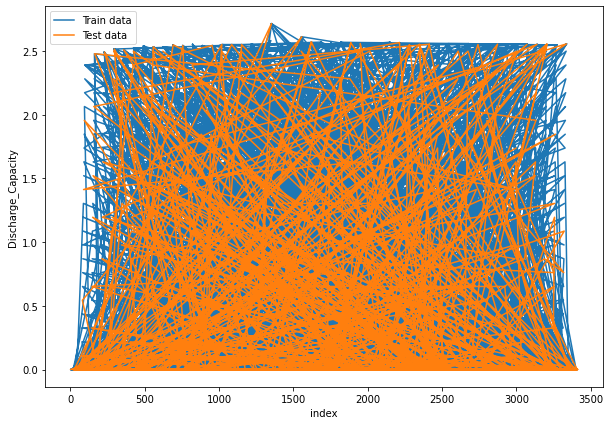

In [437]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.plot(X_train, y_train,label="Train data")
plt.plot(X_test, y_test,label="Test data")
plt.xlabel("index")
plt.ylabel("Discharge_Capacity")
plt.legend()
plt.show();

* TODO: Note: time series forecasting can often have many less data points than traditional deep learning projects (e.g. the entire history of BTC daily price data = only ~3000 samples)

* TODO: What kind of steps should we predict? E.g. 80/20 split is that realisitic? You may want to use all of the data up until the last week...

In [438]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2730,), (683,), (2730,), (683,))

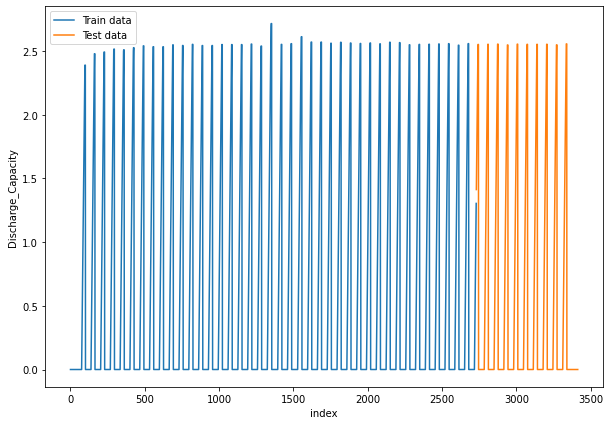

In [439]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.plot(X_train, y_train, label="Train data")
plt.plot(X_test, y_test, label="Test data")
plt.xlabel("index")
plt.ylabel("Discharge_Capacity")
plt.legend()
plt.savefig("fig2.pdf",bbox_inches="tight")
plt.show();

### TODO: Create a plotting function

Rather than retyping `matplotlib` commands to continuously plot data, let's make a plotting function we can reuse later.

In [440]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='-', start=0, end=None, label=None):
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("index")
  plt.ylabel("Discharge_Capacity")
  # plt.xlim(0,1925)
  # plt.ylim(2.8,4.5)
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

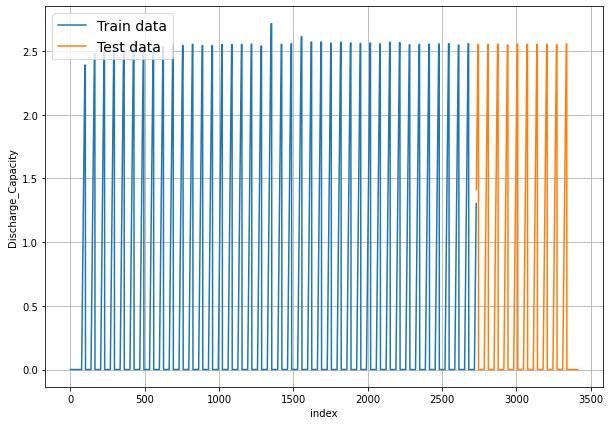

In [441]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, format="-", label="Train data")
plot_time_series(timesteps=X_test, values=y_test, format="-", label="Test data")
# plt.savefig("fig3.pdf",bbox_inches="tight")

## TODO: Modelling Experiments

* Baseline - naive forecasting
* Deep model - fully connected
  * Fully connected with different size window/horizon
  * -> How does a larger window effect a smaller horizon?
  * -> Model 1: horizon=1, window=7
  * -> Model 2: horizon=1, window=30
  * -> Model 3: horizon=7, window=30
* Sequence models
  * LSTM
  * Conv1D
* N-Beats algorithm - https://arxiv.org/pdf/1905.10437.pdf

## Model 0: Naive forecast (baseline)

Naive forecast = Use the previous timestep to predict the next timestep

$$\hat{y}_{t} = y_{t-1}$$ 

In [442]:
naive_forecast = y_test[:-1]
naive_forecast[:10]

array([1.41258 , 1.52123 , 1.629892, 1.738557, 1.847219, 1.95588 ,
       2.064554, 2.173206, 2.281871, 2.39054 ])

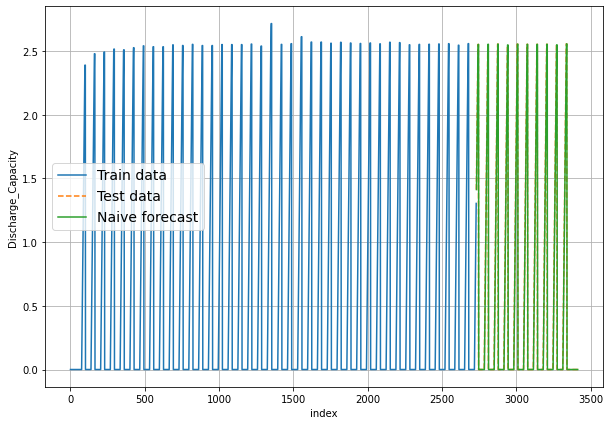

In [443]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, format="-", label="Train data")
plot_time_series(timesteps=X_test, values=y_test, format="--", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, label="Naive forecast")
plt.savefig("fig4.pdf",bbox_inches="tight");

The naive forecast looks like it's following the data well. But let's zoom in to take a better look.

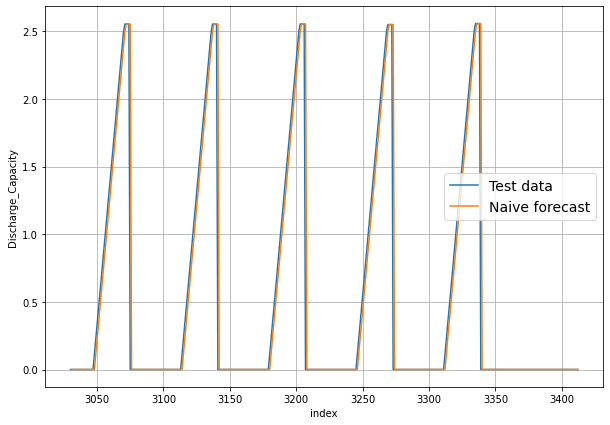

In [444]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=X_test, values=y_test, format="-", start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, label="Naive forecast")
plt.savefig("fig5.pdf",bbox_inches="tight");

When we zoom in we see the naive forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

TK - add image for naive forecast (previous step to predict next step) 

## TODO: Evaluating a time series model

TK - this can be a function for each model (compares predictions to ground truth...)

TK - metrics for evaluating time series models: https://otexts.com/fpp2/accuracy.html

Scale-dependent erros (these can't be used to make comparisons between series that involve different units):
* MAE - a forecast method that minimises the MAE will lead to forecasts of the median
* RMSE - a forecast method that minimisies RMSE will lead to forecasts of the mean

Percentage errors: 
* MAPE (mean absolute percentage error) 
* sMAPE (recommended not to be used, though it is used in forecasting competitions)

Scaled errors (these are good when comparing forecasts accuracy across series with different units) - https://otexts.com/fpp2/accuracy.html#scaled-errors:
* MASE (mean absolute scaled error) 
  * There are two kinds of MASE, one for seasonal, one for non-seasonal data
    * "To take a non-seasonal example, consider the Google stock price..."


In [445]:
import tensorflow as tf

In [446]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / mae_naive_no_season

In [447]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [448]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 0.072783835,
 'mape': 37427536.0,
 'mase': 1.0007242,
 'mse': 0.099334694,
 'rmse': 0.31517407}

## TODO: Mention other kinds of models which can be used for baselines

* TensorFlow Decision Forest
* Moving average
* Etc...
* Focused on pure TensorFlow kinds of models

## Windowing dataset

Why do we window?

TODO: We can turn our time series data into a **supervised learning problem**: use windows of the past to predict the future.

Want:

```
# Window for a week (univariate time series)
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [449]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [450]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [451]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=10, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # print(len(x)-1)
  # start = len(x) % window_size # account for data which doesn't fit into window, cut off at start
  # print(start)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0) # create 2D array of window_size
  # print(f"Window step:\n {window_step[-5:]}")
  # window_indexes = start + window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon+start-1)), axis=0).T # create 2D array of windows of size window_size
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:2], window_indexes[-2:]}")
  windowed_array = x[window_indexes] # get the original array indexed with windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [452]:
len(prices) % WINDOW_SIZE

4

In [453]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3406, 3406)

### TODO: Make train/test splits after windowing, this helps with evaluation...

In [454]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [455]:
(2224, 2224, 556, 556)

(2224, 2224, 556, 556)

In [456]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2724, 682, 2724, 682)

In [457]:
train_windows[:5], train_labels[:5]

(array([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]), array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

## TODO: Make a modelling checkpoint... 

We need to save our model's best performance. 

In [458]:
import os

In [459]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## TODO: Model 1: Dense model (window = 7, horizon = 1)

* -> How does a larger window effect a smaller horizon?
* -> Model 1: horizon=1, window=7
* -> Model 2: horizon=1, window=30
* -> Model 3: horizon=7, window=30

In [460]:
import tensorflow as tf
from tensorflow.keras import layers

In [461]:
len(train_windows), len(test_windows), len(full_windows)

(2724, 682, 3406)

In [462]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)                              
], name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_1.fit(x=train_windows, 
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
22/22 [==============================] - 0s 6ms/step - loss: 0.3161 - val_loss: 0.1993
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.1393 - val_loss: 0.0839
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0789 - val_loss: 0.0696
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0684 - val_loss: 0.0637
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0622 - val_loss: 0.0576
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0592 - val_loss: 0.0566
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0565 - val_loss: 0.0547
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0550 - val_loss: 0.0547
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0517 - val_loss: 0.0487
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 10/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0464
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 11/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0468 - val_loss: 0.0532
Epoch 12/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0540
Epoch 13/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0439
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 14/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0455 - val_loss: 0.0468
Epoch 15/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0458
Epoch 16/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0448
Epoch 17/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0446 - val_loss: 0.0440
Epoch 18/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0436
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 19/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0443
Epoch 20/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0450
Epoch 21/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0442 - val_loss: 0.0433
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 22/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0436 - val_loss: 0.0431
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 23/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0438 - val_loss: 0.0431
Epoch 24/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0428
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 25/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0441
Epoch 26/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0427
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 27/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0440 - val_loss: 0.0476
Epoch 28/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0450
Epoch 29/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0446 - val_loss: 0.0421
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 30/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0440 - val_loss: 0.0426
Epoch 31/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0433
Epoch 32/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0433 - val_loss: 0.0425
Epoch 33/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0442 - val_loss: 0.0442
Epoch 34/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0450
Epoch 35/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0471
Epoch 36/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0426
Epoch 37/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0432 - val_loss: 0.0413
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 38/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0423 - val_loss: 0.0413
Epoch 39/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0436
Epoch 40/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0484
Epoch 41/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0432
Epoch 42/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0446 - val_loss: 0.0478
Epoch 43/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.0439
Epoch 44/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0436 - val_loss: 0.0429
Epoch 45/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0417
Epoch 46/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0423 - val_loss: 0.0454
Epoch 47/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0432 - val_loss: 0.0453


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 57/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0468
Epoch 58/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0540
Epoch 59/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0459 - val_loss: 0.0460
Epoch 60/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0475
Epoch 61/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0449 - val_loss: 0.0461
Epoch 62/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0431
Epoch 63/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0431
Epoch 64/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0455 - val_loss: 0.0452
Epoch 65/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0449 - val_loss: 0.0481
Epoch 66/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0425


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 70/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0417 - val_loss: 0.0438
Epoch 71/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0420
Epoch 72/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0421 - val_loss: 0.0429
Epoch 73/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0424 - val_loss: 0.0439
Epoch 74/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0443
Epoch 75/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0426
Epoch 76/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0418
Epoch 77/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0416
Epoch 78/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0474 - val_loss: 0.0444
Epoch 79/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0438 - val_loss: 0.0423


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 84/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0422 - val_loss: 0.0446
Epoch 85/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0433 - val_loss: 0.0422
Epoch 86/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0440 - val_loss: 0.0407
Epoch 87/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0444 - val_loss: 0.0432
Epoch 88/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0427 - val_loss: 0.0408
Epoch 89/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0415 - val_loss: 0.0419
Epoch 90/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0421
Epoch 91/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0429 - val_loss: 0.0411
Epoch 92/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0421 - val_loss: 0.0408
Epoch 93/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0421 - val_loss: 0.0434


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 98/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0415 - val_loss: 0.0410
Epoch 99/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0423 - val_loss: 0.0415
Epoch 100/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0439 - val_loss: 0.0440


In [463]:
# Evaluate
model_1.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 1ms/step - loss: 0.0440


0.04404632747173309

In [464]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 2ms/step - loss: 0.0406


0.04055207595229149

### TODO: Making forecasts with a model

* We could make forecasts on the test windows, however this would end up in less prediction values than in the `y_test`
* Instead, we're going to make predictions on the full dataset windows 

In [465]:
def make_forecast(model, input_data):
  """
  Uses model to make forecasts on input_data.

  Input_data must be windowed version of whole dataset, otherwise forecasts won't match size of y_test.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model forecast on input_data from split_size-window_size onwards.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions 

In [466]:
model_1_preds = tf.squeeze(model_1.predict(test_windows))
len(model_1_preds)

682

In [467]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.5175766, 1.625562 , 1.7335534, 1.8415514, 1.9495479, 2.0575447,
       2.165555 , 2.2731838, 2.3745377, 2.4653807], dtype=float32)>

In [468]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 0.04055206,
 'mape': 35540664.0,
 'mase': 0.55756104,
 'mse': 0.08486707,
 'rmse': 0.29131952}

In [469]:
# # Model 1 with 10 epochs & no block_reward variable
# {'mae': 763.506,
#  'mape': 3.3924627,
#  'mase': 1.3412685,
#  'mse': 1933137.0,
#  'rmse': 1390.3729}

# # Model 1 with 100 epochs & no block_reward variable
# {'mae': 568.5498,
#  'mape': 2.549229,
#  'mase': 0.99878454,
#  'mse': 1172587.6,
#  'rmse': 1082.8608}

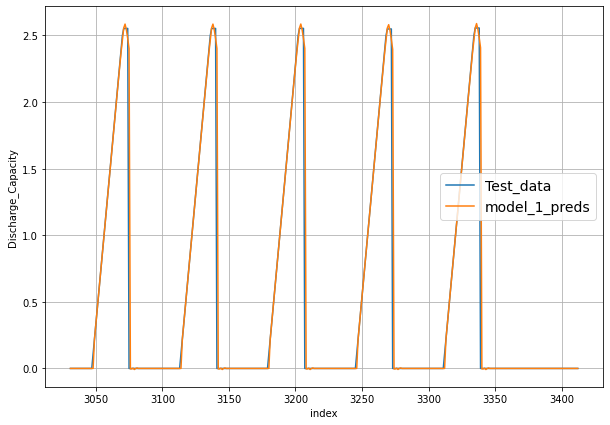

In [470]:
offset = 300
plt.figure(figsize=(10, 7))
# plt.ylim(2.9,4.5)
# plt.xlim(0,1920)
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], format="-", start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, label="model_1_preds")
plt.savefig("fig6.pdf",bbox_inches="tight")

## TODO: Model 2: Dense (window = 30, horizon = 1)

Same model as model 1 except with different data.

TK - What happens if we make a larger window & horizon?

* TK - Window & horizon values are values you can tune...

In [471]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [472]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3383, 3383)

In [473]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2706, 677, 2706, 677)

In [474]:
# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/10
85/85 [==============================] - 1s 3ms/step - loss: 0.2327 - val_loss: 0.0823
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


Epoch 2/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0785 - val_loss: 0.0829
Epoch 3/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0538
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


Epoch 4/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0549
Epoch 5/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0517
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


Epoch 6/10
85/85 [==============================] - 0s 3ms/step - loss: 0.0615 - val_loss: 0.0519
Epoch 7/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0575
Epoch 8/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0603
Epoch 9/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0496
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


Epoch 10/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0443
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


In [475]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 1ms/step - loss: 0.0443


0.044332027435302734

In [476]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 1ms/step - loss: 0.0443


0.044332027435302734

In [477]:
# Get forecast predictions
model_2_preds = make_forecast(model_2,
                              input_data=test_windows)

In [478]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 0.044332024,
 'mape': 37428390.0,
 'mase': 0.6117683,
 'mse': 0.072546236,
 'rmse': 0.2693441}

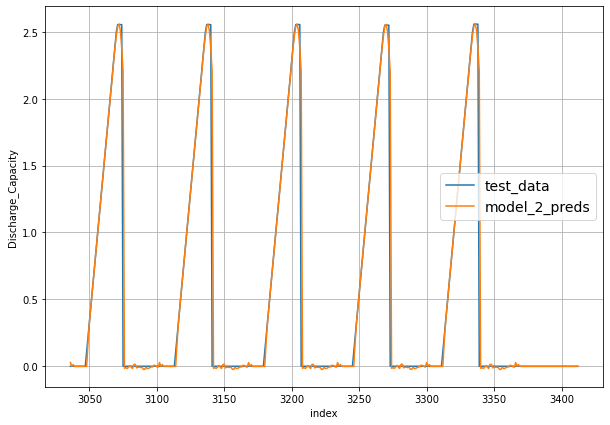

In [479]:
offset = 300
plt.figure(figsize=(10, 7))

# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, label="model_2_preds") 
plt.savefig("fig7.pdf",bbox_inches="tight")

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.



In [480]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3377, 3377)

In [481]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2701, 676, 2701, 676)

In [482]:
# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/10
85/85 [==============================] - 0s 3ms/step - loss: 0.4579 - val_loss: 0.2532
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 2/10
85/85 [==============================] - 0s 2ms/step - loss: 0.1929 - val_loss: 0.1628
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 3/10
85/85 [==============================] - 0s 2ms/step - loss: 0.1492 - val_loss: 0.1426
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 4/10
85/85 [==============================] - 0s 2ms/step - loss: 0.1332 - val_loss: 0.1247
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 5/10
85/85 [==============================] - 0s 2ms/step - loss: 0.1179 - val_loss: 0.1118
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 6/10
85/85 [==============================] - 0s 2ms/step - loss: 0.1081 - val_loss: 0.1039
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 7/10
85/85 [==============================] - 0s 2ms/step - loss: 0.1004 - val_loss: 0.0962
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 8/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0961 - val_loss: 0.0954
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 9/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0927 - val_loss: 0.0885
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 10/10
85/85 [==============================] - 0s 3ms/step - loss: 0.0886 - val_loss: 0.0866
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


In [483]:
model_3.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 1ms/step - loss: 0.0866


0.08663006871938705

TODO: The error will be higher because we're predicting 7 steps at a time... the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days out...).

In [484]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_forecast(model_3,
                              input_data=test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[1.5113783, 1.6097842, 1.7190778, 1.8102518, 1.9513139, 2.0852234,
        2.207675 ],
       [1.6202834, 1.7192583, 1.8286257, 1.9173094, 2.063961 , 2.207885 ,
        2.3161592],
       [1.7305045, 1.834202 , 1.9209173, 2.0193036, 2.193107 , 2.3432624,
        2.4280682],
       [1.8270268, 1.9340937, 2.0409477, 2.1377423, 2.3383214, 2.4840486,
        2.5262387],
       [1.9336808, 2.050179 , 2.1805487, 2.271902 , 2.468406 , 2.5708091,
        2.586937 ]], dtype=float32)>

In [485]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([0.0208729 , 0.02223304, 0.03144329, 0.03972134, 0.03406942,
        0.02720901, 0.03705236, 0.1399075 , 0.47630593, 0.59462357,
        0.42899433, 0.40610728, 0.31764635, 0.40666562, 0.5427044 ,
        0.01521386, 0.01468756, 0.01161809, 0.01310177, 0.01519218,
        0.01343557, 0.01476438, 0.01336436, 0.01457019, 0.01388395,
        0.01358343, 0.01664337, 0.01151957, 0.01340792, 0.011249  ,
        0.0108928 , 0.01451304, 0.01332931, 0.01466866, 0.0142361 ,
        0.01162299, 0.01496971, 0.01282507, 0.01730809, 0.03756026,
        0.02293868, 0.01656665, 0.01157519, 0.00800139, 0.09654801,
        0.09654801, 0.09654801, 0.08102577, 0.04998172, 0.00640014,
        0.06311495, 0.13844933, 0.23158923, 0.34025216, 0.25925416,
        0.08457063, 0.04824556, 0.01270404, 0.01546315, 0.01611379,
        0.01067919, 0.00733459, 0.0083257 , 0.01155785, 0.01111148,
        0.01856511, 0.02088383, 0.02223231, 0.03144484, 0.03972752,
        0.03389524, 0.02685019, 0.0376046

To fix this, let's adjust our `evaluate_preds()` function to work with multiple shapes of data.

In [486]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Now we've updated `evaluate_preds()` to work with multiple shapes, how does it look?

In [487]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 0.08663007,
 'mape': 48610096.0,
 'mase': 1.1884272,
 'mse': 0.056666672,
 'rmse': 0.12048955}

If we try to plot our multi-horizon predicts, we're going to get a funky looking plot.

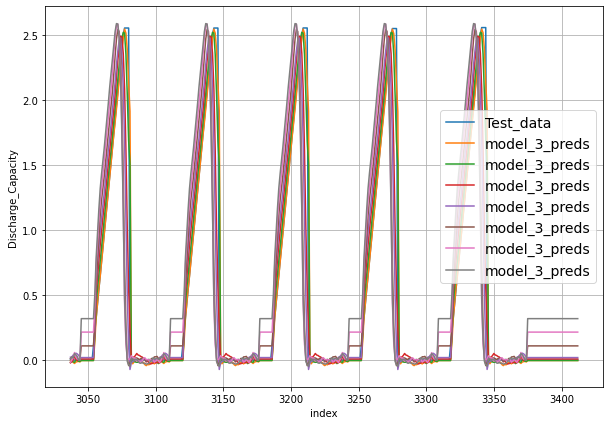

In [488]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds") 
# plt.savefig("fig8.pdf",bbox_inches="tight")

TODO: what information do we lose through aggregated the predictions? E.g. going from 7 steps at a time to one step at a time? 

Again, we can fix this by aggregating our model's predictions.

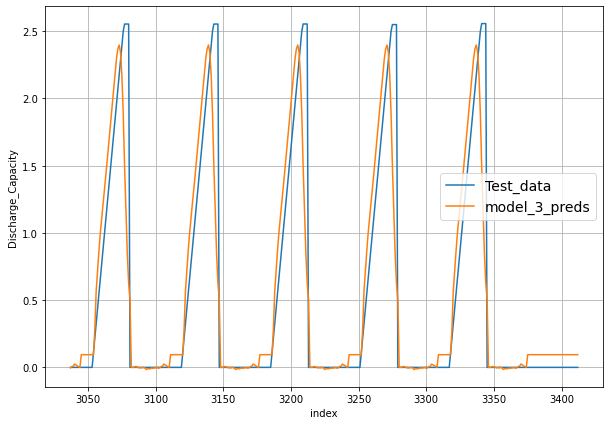

In [489]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, label="model_3_preds")
plt.savefig("fig9.pdf",bbox_inches="tight")

Which of our models is performing best so far?

In [490]:
model_1_results, model_2_results

({'mae': 0.04055206,
  'mape': 35540664.0,
  'mase': 0.55756104,
  'mse': 0.08486707,
  'rmse': 0.29131952},
 {'mae': 0.044332024,
  'mape': 37428390.0,
  'mase': 0.6117683,
  'mse': 0.072546236,
  'rmse': 0.2693441})

In [491]:
naive_results["mae"]

0.072783835

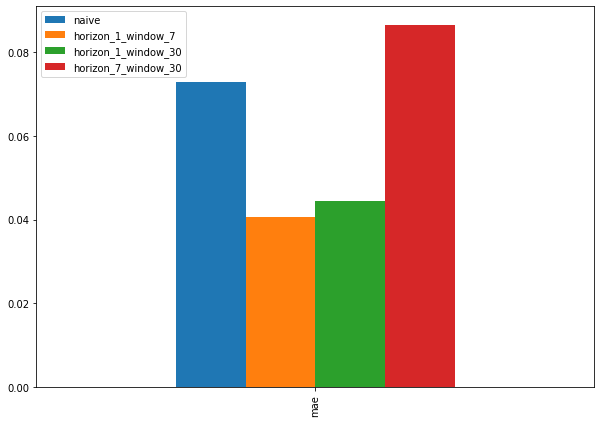

In [492]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");
plt.savefig("fig10.pdf",bbox_inches="tight")

Our naive model is performing best (it's very hard to beat a naive model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

## TODO: Model 4: Conv1D

In [493]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [494]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3406, 3406)

In [495]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2724, 682, 2724, 682)

TK - Since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In our case, the `batch_size` is handled for us but the other values will be:
* `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, our features are the previous `WINDOW_SIZE` values of Bitcoin 
* `input_dim = 1` - our model views one week of data at a time to predict the next day

Right now, our data has the `timesteps` dimension ready but we'll have to adjust it to have the `input_dim` dimension. 

In [496]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a `tf.keras.layers.Lamdba` (called a Lambda layer) to do this for us in our model.

In [497]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [498]:
# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=3, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels, 
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/10
86/86 [==============================] - 1s 4ms/step - loss: 0.1834 - val_loss: 0.0721
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 2/10
86/86 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.0561
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 3/10
86/86 [==============================] - 0s 3ms/step - loss: 0.0554 - val_loss: 0.0516
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 4/10
86/86 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0474
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 5/10
86/86 [==============================] - 0s 3ms/step - loss: 0.0510 - val_loss: 0.0482
Epoch 6/10
86/86 [==============================] - 0s 3ms/step - loss: 0.0490 - val_loss: 0.0610
Epoch 7/10
86/86 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.0452
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 8/10
86/86 [==============================] - 0s 3ms/step - loss: 0.0475 - val_loss: 0.0515
Epoch 9/10
86/86 [==============================] - 0s 3ms/step - loss: 0.0473 - val_loss: 0.0446
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 10/10
86/86 [==============================] - 0s 3ms/step - loss: 0.0485 - val_loss: 0.0459


In [499]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_13 (Lambda)           (None, 1, 7)              0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 128)            2816      
_________________________________________________________________
dense_554 (Dense)            (None, 1, 1)              129       
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [500]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 2ms/step - loss: 0.0446


0.044635530561208725

In [501]:
# Make predictions
model_4_preds = make_forecast(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.5226028, 1.6303264, 1.7380581, 1.8457956, 1.9535103, 2.0611362,
       2.168773 , 2.2759438, 2.3775523, 2.4764087], dtype=float32)>

In [502]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 0.04463553,
 'mape': 38892936.0,
 'mase': 0.61370575,
 'mse': 0.09171476,
 'rmse': 0.30284446}

## TODO: Model 5: RNN (LSTM)

TK (image) - make an image of inputs -> model -> output 

In [503]:
len(train_windows), len(train_labels)

(2724, 2724)

In [504]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.Conv1D(128, kernel_size=3, padding="causal", activation="relu")(x)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
# x = layers.Dropout(0.05)(x)
x = layers.LSTM(128, activation="relu")(x)
# print(x.shape)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/10
86/86 [==============================] - 2s 7ms/step - loss: 0.3242 - val_loss: 0.1664
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


Epoch 2/10
86/86 [==============================] - 0s 5ms/step - loss: 0.1247 - val_loss: 0.0779
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


Epoch 3/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0710 - val_loss: 0.0596
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


Epoch 4/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0615 - val_loss: 0.0584
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


Epoch 5/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0585 - val_loss: 0.0585
Epoch 6/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0577 - val_loss: 0.0579
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


Epoch 7/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0574 - val_loss: 0.0532
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


Epoch 8/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0547 - val_loss: 0.0619
Epoch 9/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0531 - val_loss: 0.0562
Epoch 10/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0547 - val_loss: 0.0510
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


In [505]:
model_5.summary()

Model: "model_5_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 7)]               0         
_________________________________________________________________
lambda_14 (Lambda)           (None, 1, 7)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               69632     
_________________________________________________________________
dense_555 (Dense)            (None, 1)                 129       
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [506]:
# Make predictions with our LSTM model
model_5_preds = make_forecast(model_5, test_windows)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.5366364, 1.6443355, 1.750837 , 1.8561305, 1.9602121, 2.0630836,
       2.1647668, 2.2652445, 2.3645563, 2.4627223], dtype=float32)>

In [507]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 0.051039178,
 'mape': 39533936.0,
 'mase': 0.7017512,
 'mse': 0.088027634,
 'rmse': 0.29669452}

Now that we've got a windowed dataset, let's separate features (`X`) from labels (`y`).

Remember in our windowed dataset, we're trying to use the previous `WINDOW_SIZE` steps to predict `HORIZON` steps.

```
# Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE -> HORIZON
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

We'll also remove the `NaN` values using pandas `dropna()` method, this equivalent to starting our windowing function at `sample 0 (the first sample) + WINDOW_SIZE`.

## TODO: Model 8: N-BEATs algorithm

* Build model - Figure 1: https://arxiv.org/pdf/1905.10437.pdf
* Hyperparameters for N-Beats paper are available in Appendix D
* TODO: Does ensembling with different loss functions lead to some kind of pseudo uncertainty...?
* “N-BEATS is implemented and trained in TensorFlow”

In [508]:
# Create NBeatsBlock
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs 
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # TODO: are these the right dimensions?
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [509]:
# dummy_inputs = tf.expand_dims(tf.range(7) + 1, axis=0)
# dummy_inputs

In [510]:
# nbeats_block_layer(dummy_inputs)

In [511]:
# Demo the subtract layer...
X1 = tf.range(10) + 10
X2 = tf.range(10)
input_1 = layers.Input(shape=(10))
input_2 = layers.Input(shape=(10))
subtract_layer = layers.subtract([input_1, input_2])
subtract_model = tf.keras.Model(inputs=[input_1, input_2], outputs=subtract_layer)
print(X1)
print(X2)
subtract_model([X1, X2]).numpy()

tf.Tensor([10 11 12 13 14 15 16 17 18 19], shape=(10,), dtype=int32)
tf.Tensor([0 1 2 3 4 5 6 7 8 9], shape=(10,), dtype=int32)


array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.], dtype=float32)

In [512]:
# Instantiate input variables
WINDOW_SIZE = 7 # how far to lookback
HORIZON = 1 # how far to predict forward
BATCH_SIZE = 1024 # how many samples to look at per batch

# Values from paper (see Figure 1/Appendix D)
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [513]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
data_rawdata.head()

,Discharge_Capacity
index,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [514]:
# Add windowed columns
data_rawdata_nbeats = data_rawdata.copy()
for i in range(WINDOW_SIZE):
  data_rawdata_nbeats[f"Discharge_Capacity+{i+1}"] = data_rawdata_nbeats["Discharge_Capacity"].shift(i+1)
data_rawdata_nbeats.dropna().head()

,Discharge_Capacity,Discharge_Capacity+1,Discharge_Capacity+2,Discharge_Capacity+3,Discharge_Capacity+4,Discharge_Capacity+5,Discharge_Capacity+6,Discharge_Capacity+7
index,,,,,,,,
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [515]:
# Make features and labels
X = data_rawdata_nbeats.dropna().drop("Discharge_Capacity", axis=1)
y = data_rawdata_nbeats.dropna()["Discharge_Capacity"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2724, 2724, 682, 682)

In [516]:
# Create TensorFlow dataset - from_tensor_slices is best when your data fits in memory: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels & features
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

In [517]:
tf.random.set_seed(42)

# Setup NBEATs Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# Build stacks of blocks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# Create initial backcast and forecast input
residuals, forecast = nbeats_block_layer(stack_input)

# Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") # https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")
stack_model = tf.keras.Model(inputs=stack_input, outputs=forecast, name="Stack_Model")

# Compile
stack_model.compile(loss="mae",
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=["mae", "mse"])

# Fit
stack_model.fit(train_dataset,
                epochs=5000,
                validation_data=test_dataset,
                verbose=0,
                # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00537: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00669: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00782: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00882: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00982: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 01082: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 01182: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 01282: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.


In [518]:
stack_model.evaluate(test_dataset)

1/1 [==============================] - 0s 26ms/step - loss: 0.0029 - mae: 0.0029 - mse: 1.9710e-04


[0.002885596128180623, 0.002885596128180623, 0.00019710135529749095]

In [519]:
stack_preds = make_forecast(stack_model, test_dataset)
stack_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.5212435, 1.6299049, 1.7385626, 1.8472238, 1.955856 , 2.0645382,
       2.1732738, 2.2819927, 2.390384 , 2.4728065], dtype=float32)>

In [520]:
stack_results = evaluate_preds(y_true=y_test,
                               y_pred=stack_preds)
stack_results

{'mae': 0.0028855961,
 'mape': 2422.9287,
 'mase': 0.039674826,
 'mse': 0.00019710136,
 'rmse': 0.014039279}

In [521]:
# TODO: This will error out unless a "get_config()" method is implemented
stack_model.save("stack_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: stack_model/assets


INFO:tensorflow:Assets written to: stack_model/assets


# TODO: Create an ensemble

* We'll combine the predictions of 3 versions of `simple_model` and see what happens:
  * MAE
  * MSE
  * MAPE

In [522]:
%%time

tf.random.set_seed(42)

preds = {}
for loss_function in ["mae", "mse", "mape"]:
  print(f"Optimizing model by reducing: {loss_function}")

  # construct simple model
  simple_model = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
  ])

  simple_model.compile(loss=loss_function,
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["mae", "mse"])

  simple_model.fit(train_dataset,
                   epochs=1000,
                   verbose=0,
                   validation_data=test_dataset,
                   # Stop when a model stops improving for ~200 epochs and lower the learning rate when improvement plateau's
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                              tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

  simple_model_preds = tf.squeeze(simple_model.predict(test_dataset))

  # Append predictions with target loss function to dictionary
  preds[loss_function] = simple_model_preds

Optimizing model by reducing: mae

Epoch 00435: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00549: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00653: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00753: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00853: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00953: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Optimizing model by reducing: mse

Epoch 00498: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00599: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00699: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00799: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00899: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00999: ReduceLROnPlateau r

In [523]:
ensemble_preds = np.array(list(preds.values()))
ensemble_preds.shape

(3, 682)

In [524]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0))
ensemble_results

{'mae': 0.0068574734,
 'mape': 266566.03,
 'mase': 0.09428522,
 'mse': 0.00052686455,
 'rmse': 0.02295353}

### Plotting the variance (prediction intervals) of our ensemble

* See here for more: https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html#Continuous-Errors
* And here: https://stackoverflow.com/a/12958534/7900723 

In [525]:
# Get the variance of different ensemble preds (these are how much predictions vary accross loss metrics)
ensemble_var = tf.math.reduce_variance(ensemble_preds, axis=0)
ensemble_var[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.41928777, 0.50866354, 0.60437745, 0.70391625, 0.80344313,
       0.9069317 , 1.0166368 , 1.1325465 , 1.2506533 , 1.3613014 ],
      dtype=float32)>

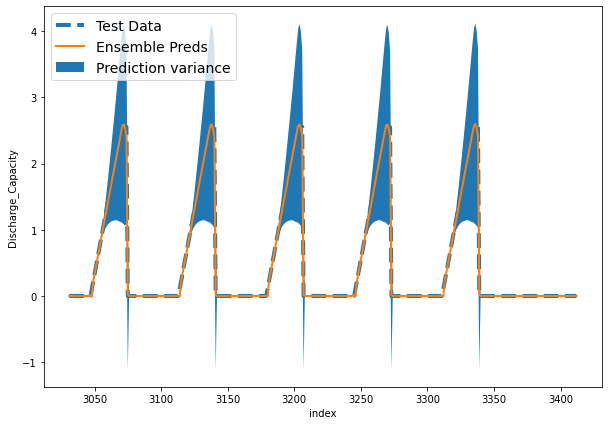

In [527]:
# Plot the variance/median of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

offset=300
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "--",linewidth=4, label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:],"-",linewidth=2, label="Ensemble Preds")
plt.xlabel("index")
plt.ylabel("Discharge_Capacity")
plt.fill_between(X_test.index[offset:], 
                 (ensemble_median-ensemble_var)[offset:], 
                 (ensemble_median+ensemble_var)[offset:], label="Prediction variance")
plt.legend(loc="upper left", fontsize=14)
plt.savefig("fig11.pdf",bbox_inches="tight");

## TODO: Plot uncertainty/prediction intervals on the future forecasts

* To do this, make a function to make future forecasts in an ensemble format
* Return the future predictions as well as their variance(s) (from the ensemble)

# TODO: Why forecasting is BS (turkey problem)

TK - inject a turkey problem piece of data into the model & see how it effects (e.g. 1 data point that's 50x of outlier)

* See this video: https://youtu.be/hRwimmE2wEk
* Open system: beware (like fortune telling), see Mark Saroufim's tweet - https://twitter.com/marksaroufim/status/1366871736604532739?s=20
* Closed system: try it out

# TODO: Exercises

* Does scaling the data help for multivariate data? (e.g. getting all of the values between 0 & 1) 

# TODO: Extra-curriculum

* Evaluation metrics - https://otexts.com/fpp2/accuracy.html 
* 